### Testing Model-Aware RL

In [1]:
# !pip install Box2D
# !pip install 'gym[all]'
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import time
import sys
from tqdm import tqdm

from models import DQNetwork
from agent import Agent
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
env_id = 'CartPole-v0'
env = gym.make(env_id)

In [3]:
env.observation_space #continuous with 4 observations for each state

Box(4,)

In [4]:
env.action_space #discrete with 2 actions

Discrete(2)

### Running an agent using random policy π

In [5]:
env.reset()
total_reward = 0
for i in range(1000):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    total_reward += reward
    #env.render() #sudo-human
    if(done):
        break
print("Reward: {}\nIteration #: {}\nEnding state:\n{}".format(total_reward, i, state))

Reward: 15.0
Iteration #: 14
Ending state:
[ 0.13890406  0.97856324 -0.2408044  -1.750641  ]


### Implement DQN Agent

In [6]:
actor = Agent(env.observation_space.shape[0], env.action_space.n)
#To load an agent
# actor.load_model("../model/policy.pth")

In [7]:
scores = []  # List with all scores per episode
score_d = deque(maxlen=100) #Last 100 episodes
NUM_EPISODES = 5_000
ENV_SOLVED = 175 #How many mean iterations to stay 'alive' in order to succeed?

### Train Agent

In [8]:
def get_epsilon_i(num_episode, epsilon_min = 0.01):
    """Simple Epsilon Decay over total number of episodes. Stochastic in nature when summed over"""
    epsilon = 1.0/num_episode
    return max(epsilon, epsilon_min)

In [9]:
for epoch in range(1, NUM_EPISODES+1):
    env_info = env.reset()   # reset the environment
    state = env.reset()      # get the initial state
    score = 0                # initialize the score
    i = 0
    while True:
        i += 1
        epsilon = get_epsilon_i(epoch)
        action = actor.get_action(state, epsilon)              # select an action
        next_state, reward, done, _ = env.step(action)         # step into next state
        transition = (state, action, reward, next_state, done) # set transition
        actor.step(transition)                                 # Train the model
        score += reward                                        # update the score
        state = next_state                                     # roll over the state to next time step
        if done:                                               # exit loop if episode finished
            break
            
    scores.append(score)
    score_d.append(score)
    
    if(epoch%50 == 0):#Print stats every 50 episodes
        print(f"\r{epoch}: Score: {score}; Last 100 mean: {np.mean(score_d)}; Epsilon: {epsilon}", end="")
    if(np.mean(score_d) >= ENV_SOLVED):
        print(f"\n\nSolved at episode {epoch} with score: {score} and mean: {np.mean(score_d)}")
        break

2350: Score: 200.0; Last 100 mean: 163.52; Epsilon: 0.01

Solved at episode 2359 with score: 200.0 and mean: 175.77


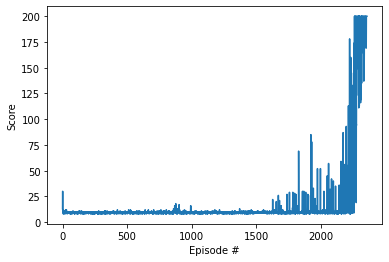

In [10]:
plt.plot(scores)
plt.xlabel("Episode #")
plt.ylabel("Score")
plt.show()

In [11]:
from agent import WEIGHT_STATE
print(WEIGHT_STATE)

0.1


In [12]:
# Weight = steps to converge, last 100 episodes' reward
# 0 = 2137, 176.09
# 0.1 = 1765, 175.34
# 0.4 = 2173, 175.86
# 0.8 = 2467, 176.22
# 0.95 = 2481, 175.61
# 1 = not converged